# MODELOS PREDICTIVOS CON MACHINE/DEEP LEARNING

Creamos 2 modelos, un XGBoost y una Red Neuronal, para predecir la probabilidad de pago del prestamo. 

Si la probabilidad del pago del prestamo es mayor a un 80% se le concede el prestamo, sino no.

Además se hace un análisis de las variables más importantes y una visualización de los modelos.

In [7]:
pip install xgboost scipy

Note: you may need to restart the kernel to use updated packages.


# Modelo de Machine Learning XGBoost

# Cargas de Bibliotecas, Procesamiento, Creación del Modelo, Entrenamiento, Predicción y Guardado de; Modelo, Resultados, Visualización y Metricas 

In [8]:
# modelo_xgb_sin_earlystopping.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- configuración ----------------
RANDOM_STATE = 42
FILE_PATH = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"  # ajustar si hace falta
TARGET_COL = "NON_COMPLIANT_CONTRACT"
APPROVAL_THRESHOLD = 0.8
MODEL_OUTPUT = "xgb_pipeline_no_earlystop.joblib"
# -----------------------------------------------

# ---- carga y extracción target (robusto) ----
df = pd.read_parquet(FILE_PATH)

y = df[TARGET_COL].copy()
if y.dtype == bool:
    y = y.astype(int)
elif y.dtype == object:
    vals = y.dropna().astype(str).str.lower().unique()
    if set(vals).issubset({"true","t","yes","y","false","f","no","n"}):
        y = y.astype(str).str.lower().map(lambda v: 1 if v in {"true","t","yes","y"} else 0)
    elif len(vals) == 2:
        mapping = {vals[0]: 0, vals[1]: 1}
        y = y.astype(str).map(mapping)
    else:
        raise ValueError("TARGET no binario")
else:
    y = y.astype(int)

X = df.drop(columns=[TARGET_COL])

# ---- splits: train / val / test (70/10/20) ----
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=y_temp
)
# (resultado: train ~70%, val ~10%, test ~20%)

# ---- columnas por tipo ----
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","bool","category"]).columns.tolist()

# ---- preprocesador ligero ----
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    [("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---- transformar conjuntos ----
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# nombres de features procesadas (mantenemos 1:1 aquí)
proc_feature_names = num_cols + cat_cols

# ---- cálculo de balance y modelo base ----
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

# ---- RandomizedSearchCV para mejorar (sin volverse lento) ----
param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": stats.randint(3, 9),
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "gamma": [0, 0.1, 0.5],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Ejecutando RandomizedSearchCV...")
rs.fit(X_train_proc, y_train)
print("Mejores parámetros:", rs.best_params_)

best_model = rs.best_estimator_
# Nota: RandomizedSearchCV con refit=True ya entrena best_model sobre X_train_proc.

# ---- entrenamiento final (sin early stopping) ----
# (si quieres un re-fit explícito con los mejores parámetros, descomenta la línea siguiente)
# best_model.fit(X_train_proc, y_train)

# ---- predicción y evaluación ----
y_prob = best_model.predict_proba(X_test_proc)[:, 1]
y_pred = (y_prob >= APPROVAL_THRESHOLD).astype(int)

auc = roc_auc_score(y_test, y_prob)
print(f"AUC (ROC): {auc:.4f}")
print("\nClassification report (threshold = {:.2f}):".format(APPROVAL_THRESHOLD))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ---- guardar pipeline final (preprocessor + modelo) ----
final_pipeline = make_pipeline(preprocessor, best_model)
joblib.dump(final_pipeline, MODEL_OUTPUT)
print("Pipeline guardado en:", MODEL_OUTPUT)

# ------------------ Visualizaciones ------------------
# 1) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
print("ROC guardada en: roc_curve.png")
plt.close()

# 2) Heatmap de correlación (sólo variables numéricas originales)
if len(num_cols) >= 2:
    corr = X_train[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation heatmap (numeric features)")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    print("Heatmap guardado en: correlation_heatmap.png")
    plt.close()

# 3) Importancia de características (top 20, según gain)
try:
    fmap = best_model.get_booster().get_score(importance_type="gain")
    importance = []
    for k, v in fmap.items():
        # k es "f0","f1",...
        idx = int(k[1:])
        name = proc_feature_names[idx] if idx < len(proc_feature_names) else f"f{idx}"
        importance.append((name, v))
    importance = sorted(importance, key=lambda x: x[1], reverse=True)[:20]
    if importance:
        names, vals = zip(*importance)
        plt.figure(figsize=(8, max(4, 0.25*len(names))))
        plt.barh(range(len(names))[::-1], vals)
        plt.yticks(range(len(names)), names[::-1])
        plt.xlabel("Gain")
        plt.title("Top feature importances (gain)")
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        print("Importancia de variables guardada en: feature_importance.png")
        plt.close()
except Exception:
    # si no hay acceso a get_booster(), ignoramos
    pass

print("Proceso completado.")


Ejecutando RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.8}
AUC (ROC): 0.7573

Classification report (threshold = 0.80):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29949
           1       0.39      0.13      0.20      2647

    accuracy                           0.91     32596
   macro avg       0.66      0.56      0.58     32596
weighted avg       0.88      0.91      0.89     32596

Confusion matrix:
 [[29401   548]
 [ 2297   350]]
Pipeline guardado en: xgb_pipeline_no_earlystop.joblib
ROC guardada en: roc_curve.png
Heatmap guardado en: correlation_heatmap.png
Importancia de variables guardada en: feature_importance.png
Proceso completado.


# Visualización

📁 Archivos en el directorio actual:
  - .bashrc
  - .profile
  - .bash_logout
  - xgb_pipeline_no_earlystop.joblib
  - xgb_pipeline_no_earlystop.h5
  - .cache
  - .npm
  - .jupyter
  - .ipython
  - roc_curve.png
  - correlation_heatmap.png
  - feature_importance.png
  - .local
  - .conda
  - .config
  - .wget-hsts
  - work

✔️ Directorio actual: /home/jovyan

📦 Cargando modelo guardado...
Modelo cargado correctamente:
 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TOTAL_INCOME',
                                                   'AMOUNT_PRODUCT',
 

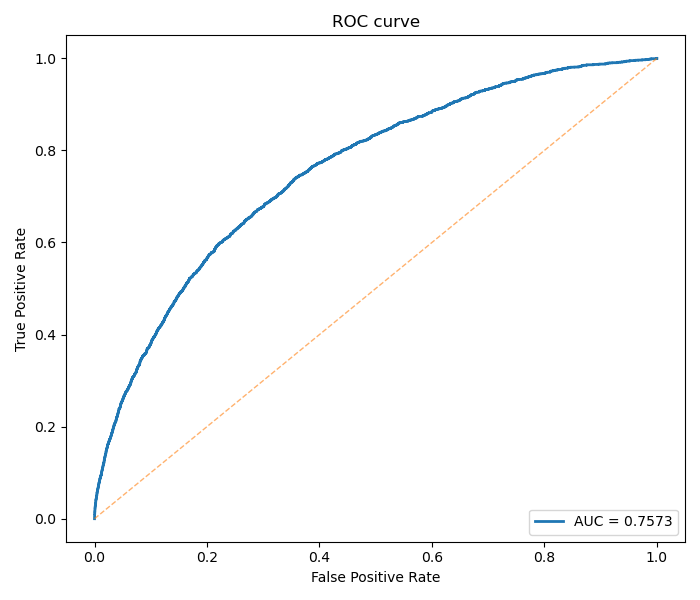


🖼️ Heatmap de correlación:


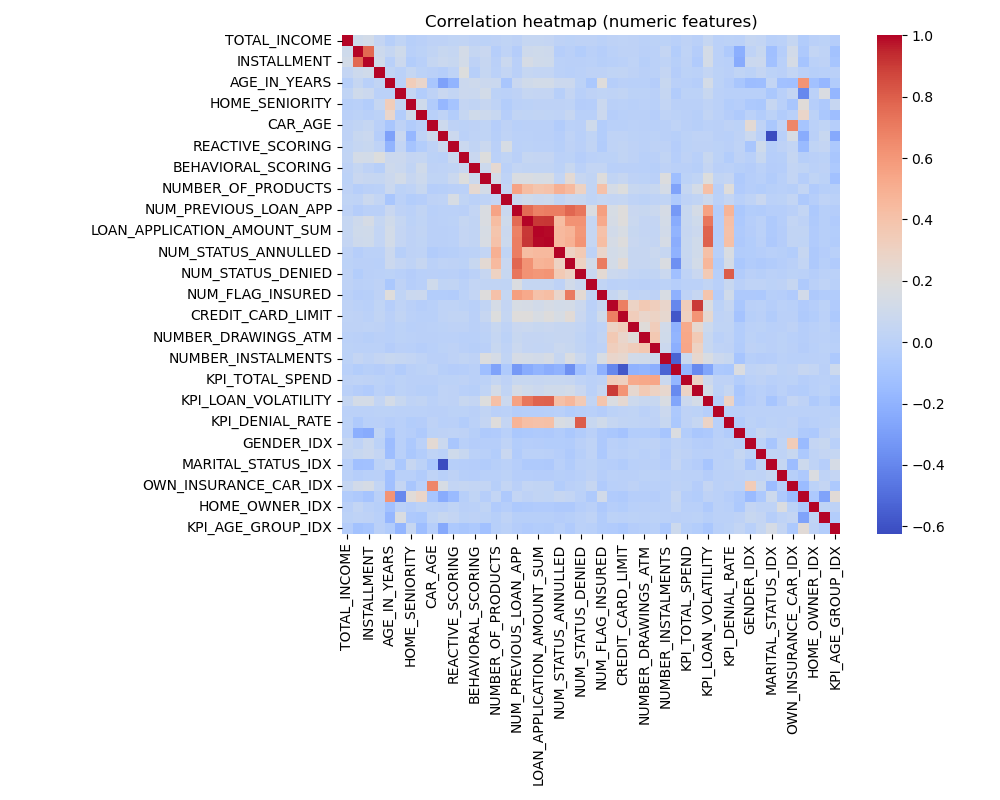


🖼️ Importancia de features:


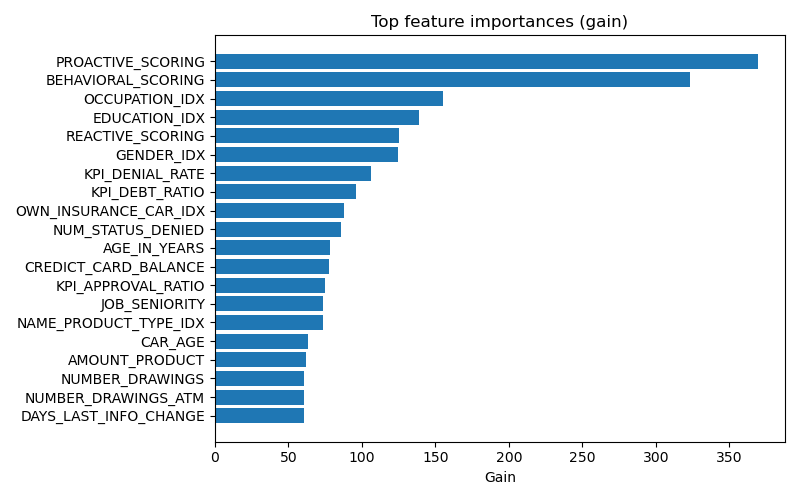


🔍 Vista previa de predicciones:


,actual,prob,pred
0,0,0.350252,0
1,0,0.379254,0
2,0,0.660004,1
3,0,0.157122,0
4,0,0.513371,1
5,0,0.061929,0
6,0,0.138349,0
7,0,0.292261,0
8,0,0.127057,0
9,0,0.225297,0


In [9]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ----------------- CONFIG -----------------
MODEL_FILE = "xgb_pipeline_no_earlystop.joblib"
ROC_FILE = "roc_curve.png"
HEATMAP_FILE = "correlation_heatmap.png"
IMP_FILE = "feature_importance.png"
PARQUET_FILE = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"
TARGET_COL = "NON_COMPLIANT_CONTRACT"
# ------------------------------------------


# ==========================
# 1) Ver archivos existentes
# ==========================
print("📁 Archivos en el directorio actual:")
for f in os.listdir():
    print("  -", f)

print("\n✔️ Directorio actual:", os.getcwd())


# ==========================
# 2) Cargar modelo
# ==========================
print("\n📦 Cargando modelo guardado...")
pipeline = joblib.load(MODEL_FILE)
print("Modelo cargado correctamente:\n", pipeline)


# ==========================
# 3) Cargar dataset y predecir
# ==========================
print("\n📄 Cargando dataset...")
df = pd.read_parquet(PARQUET_FILE)
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

print("Dataset cargado. Shape:", df.shape)

print("\n🔮 Generando predicciones...")
y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = pipeline.predict(X)

# ==========================
# 4) Métricas
# ==========================
print("\n📊 Métricas del modelo:")
print("AUC:", roc_auc_score(y, y_prob))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))


# ==========================
# 5) Mostrar imágenes guardadas
# ==========================
def mostrar_imagen(path, titulo):
    if os.path.exists(path):
        print(f"\n🖼️ {titulo}:")
        display(Image(filename=path))
    else:
        print(f"⚠️ No se encontró {path}")

mostrar_imagen(ROC_FILE, "Curva ROC")
mostrar_imagen(HEATMAP_FILE, "Heatmap de correlación")
mostrar_imagen(IMP_FILE, "Importancia de features")


# ==========================
# 6) Vista previa de predicciones
# ==========================
print("\n🔍 Vista previa de predicciones:")
preview = pd.DataFrame({
    "actual": y,
    "prob": y_prob,
    "pred": y_pred
})
display(preview.head(10))


# Creación del Archivo H5 para visualización 

In [10]:
# -----------------------------
# Guardar pipeline también en .h5 (corregido)
# -----------------------------
import h5py
import pickle
from datetime import datetime
import numpy as np

H5_MODEL_FILE = "xgb_pipeline_no_earlystop.h5"

# serializar pipeline con pickle
pickled_pipeline = pickle.dumps(final_pipeline, protocol=pickle.HIGHEST_PROTOCOL)

# almacenar como array de uint8
pickled_array = np.frombuffer(pickled_pipeline, dtype=np.uint8)

with h5py.File(H5_MODEL_FILE, "w") as f:
    f.create_dataset("pipeline_pickle", data=pickled_array)
    f.attrs["created_at"] = datetime.utcnow().isoformat() + "Z"
    f.attrs["source"] = "xgb_pipeline_no_earlystop.joblib"

print("Pipeline guardado correctamente en HDF5:", H5_MODEL_FILE)


Pipeline guardado correctamente en HDF5: xgb_pipeline_no_earlystop.h5


# RED NEURONAL PERCEPTRÓN MULTICAPA

# CARGA DE DATOS, PREPROCESAMIENTO Y CONSTRUCCIÓN DEL MODELO

In [ ]:
"""
Script para entrenamiento de red neuronal en problemas de clasificación desbalanceada, este modelo no ha sido óptimo para su principal objetivo
por lo que se deja como referencia de técnicas avanzadas de preprocesamiento y construcción de modelos.

El modelo de referencia principal es el XGBOOST para este tipo de casos.
"""

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

# Scikit-learn para preprocesamiento y evaluación
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve, precision_recall_curve, 
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split

# Imbalanced-learn para manejo de clases desbalanceadas
from imblearn.over_sampling import SMOTE

# TensorFlow/Keras para construcción del modelo
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Input, Embedding, 
    Flatten, Concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras import regularizers

# Configuración de advertencias
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN DEL SCRIPT
# ============================================================================

RUTA_DATOS = 'C:/Users/PcVip/Documents/GitHub/Big-Daddy/data/curated/Master_Model_FinPlus.parquet'
VARIABLE_OBJETIVO = "NON_COMPLIANT_CONTRACT"
SEMILLA_ALEATORIA = 42
EPOCAS = 50
TAMANO_LOTE = 512
DIMENSION_EMBEDDING = 8
TAMANO_PRUEBA = 0.2

# ============================================================================
# 1. CARGA Y ANÁLISIS INICIAL DE DATOS
# ============================================================================

print("=" * 80)
print("ANÁLISIS DE DATOS - PROBLEMA DE CLASE DESBALANCEADA")
print("=" * 80)

# Cargar datos desde archivo Parquet
datos = pd.read_parquet(RUTA_DATOS).fillna(0)

# Análisis de distribución de clases
distribucion_clases = datos[VARIABLE_OBJETIVO].value_counts()
porcentaje_clases = distribucion_clases / len(datos) * 100

print(f"\nDistribución de clases:")
print(f"  Clase 0 (Cumplimiento): {distribucion_clases[0]} "
      f"({porcentaje_clases[0]:.1f}%)")
print(f"  Clase 1 (Incumplimiento): {distribucion_clases[1]} "
      f"({porcentaje_clases[1]:.1f}%)")
print(f"  Ratio de desbalanceo: {distribucion_clases[0]/distribucion_clases[1]:.1f}:1")

# ============================================================================
# 2. IDENTIFICACIÓN Y SEPARACIÓN DE VARIABLES
# ============================================================================

# Definir columnas a excluir del análisis
columnas_excluir = ['CLIENT_ID', VARIABLE_OBJETIVO]

# Obtener todas las características disponibles
todas_caracteristicas = [
    col for col in datos.columns if col not in columnas_excluir
]

# Identificar variables categóricas (object o con menos de 20 valores únicos)
caracteristicas_categoricas = [
    col for col in todas_caracteristicas 
    if datos[col].dtype == 'object' or datos[col].nunique() < 20
]

# Las variables numéricas son las restantes
caracteristicas_numericas = [
    col for col in todas_caracteristicas 
    if col not in caracteristicas_categoricas
]

print(f"\n✓ Características identificadas:")
print(f"  Total: {len(todas_caracteristicas)}")
print(f"  Categóricas: {len(caracteristicas_categoricas)}")
print(f"  Numéricas: {len(caracteristicas_numericas)}")

# ============================================================================
# 3. SEPARACIÓN ESTRATIFICADA DE DATOS
# ============================================================================

# Separar características (X) y variable objetivo (y)
X = datos.drop(columns=[VARIABLE_OBJETIVO])
y = datos[VARIABLE_OBJETIVO]

# Dividir en conjuntos de entrenamiento y prueba con estratificación
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, 
    test_size=TAMANO_PRUEBA, 
    stratify=y, 
    random_state=SEMILLA_ALEATORIA
)

print(f"\n✓ Separación entrenamiento/prueba:")
print(f"  Entrenamiento: {len(X_entrenamiento)} muestras "
      f"({dict(y_entrenamiento.value_counts())})")
print(f"  Prueba: {len(X_prueba)} muestras "
      f"({dict(y_prueba.value_counts())})")

# ============================================================================
# 4. PREPROCESAMIENTO AVANZADO
# ============================================================================

def preprocesamiento_avanzado(
    X_entrenamiento, 
    y_entrenamiento, 
    X_prueba, 
    columnas_categoricas, 
    columnas_numericas
):
    """
    Realiza preprocesamiento completo de datos incluyendo:
    1. Codificación de variables categóricas con manejo de valores nuevos
    2. Escalado de variables numéricas
    3. Balanceo de clases con SMOTE
    """
    
    # ========== 4.1. Codificación de variables categóricas ==========
    
    codificadores_etiqueta = {}
    X_cat_entrenamiento_codificado = []
    X_cat_prueba_codificado = []
    
    for col in columnas_categoricas:
        # Crear y entrenar codificador
        codificador = LabelEncoder()
        datos_entrenamiento = X_entrenamiento[col].fillna('NaN').astype(str)
        codificador.fit(datos_entrenamiento)
        codificadores_etiqueta[col] = codificador
        
        # Transformar datos de entrenamiento
        X_cat_entrenamiento_codificado.append(
            codificador.transform(datos_entrenamiento)
        )
        
        # Transformar datos de prueba con manejo de valores nuevos
        datos_prueba = X_prueba[col].fillna('NaN').astype(str)
        datos_prueba_masked = datos_prueba.copy()
        
        # Identificar valores no vistos durante el entrenamiento
        mascara_no_vistos = ~datos_prueba_masked.isin(codificador.classes_)
        datos_prueba_masked[mascara_no_vistos] = 'Desconocido'
        
        # Agregar categoría 'Desconocido' si no existe
        if 'Desconocido' not in codificador.classes_:
            codificador.classes_ = np.append(codificador.classes_, 'Desconocido')
        
        X_cat_prueba_codificado.append(
            codificador.transform(datos_prueba_masked)
        )
    
    # Convertir listas a arrays
    if columnas_categoricas:
        X_cat_entrenamiento = np.column_stack(X_cat_entrenamiento_codificado)
        X_cat_prueba = np.column_stack(X_cat_prueba_codificado)
    else:
        X_cat_entrenamiento = np.array([])
        X_cat_prueba = np.array([])
    
    # ========== 4.2. Preprocesamiento de variables numéricas ==========
    
    escalador = StandardScaler()
    
    if columnas_numericas:
        # Calcular medianas para imputación de valores faltantes
        medianas_caracteristicas = X_entrenamiento[columnas_numericas].median().to_dict()
        
        # Escalar datos de entrenamiento
        X_num_entrenamiento_escalado = escalador.fit_transform(
            X_entrenamiento[columnas_numericas].fillna(medianas_caracteristicas)
        )
        
        # Escalar datos de prueba usando mismos parámetros
        X_num_prueba_escalado = escalador.transform(
            X_prueba[columnas_numericas].fillna(medianas_caracteristicas)
        )
    else:
        X_num_entrenamiento_escalado = np.array([])
        X_num_prueba_escalado = np.array([])
        medianas_caracteristicas = {}
    
    # ========== 4.3. Balanceo de clases con SMOTE ==========
    
    print("\n✓ Aplicando SMOTE para balancear clases...")
    
    # Combinar características categóricas y numéricas para SMOTE
    if X_cat_entrenamiento.shape[1] > 0 and X_num_entrenamiento_escalado.shape[1] > 0:
        X_combinado_entrenamiento = np.hstack(
            [X_cat_entrenamiento, X_num_entrenamiento_escalado]
        )
    elif X_cat_entrenamiento.shape[1] > 0:
        X_combinado_entrenamiento = X_cat_entrenamiento
    else:
        X_combinado_entrenamiento = X_num_entrenamiento_escalado
    
    # Aplicar SMOTE (submuestreo de clase mayoritaria, sobremuestreo de minoritaria)
    smote = SMOTE(sampling_strategy=0.5, random_state=SEMILLA_ALEATORIA)
    X_entrenamiento_balanceado, y_entrenamiento_balanceado = smote.fit_resample(
        X_combinado_entrenamiento, y_entrenamiento
    )
    
    # Separar características nuevamente después del balanceo
    if X_cat_entrenamiento.shape[1] > 0 and X_num_entrenamiento_escalado.shape[1] > 0:
        X_cat_entrenamiento_bal = X_entrenamiento_balanceado[:, :X_cat_entrenamiento.shape[1]]
        X_num_entrenamiento_bal = X_entrenamiento_balanceado[:, X_cat_entrenamiento.shape[1]:]
    elif X_cat_entrenamiento.shape[1] > 0:
        X_cat_entrenamiento_bal = X_entrenamiento_balanceado
        X_num_entrenamiento_bal = np.array([])
    else:
        X_cat_entrenamiento_bal = np.array([])
        X_num_entrenamiento_bal = X_entrenamiento_balanceado
    
    print(f"  Distribución después de SMOTE: {np.bincount(y_entrenamiento_balanceado)}")
    
    # ========== 4.4. Crear diccionario de preprocesador ==========
    
    preprocesador = {
        'codificadores_etiqueta': codificadores_etiqueta,
        'escalador': escalador,
        'medianas_caracteristicas': medianas_caracteristicas,
        'caracteristicas_categoricas': columnas_categoricas,
        'caracteristicas_numericas': columnas_numericas
    }
    
    return (
        X_cat_entrenamiento_bal, 
        X_num_entrenamiento_bal, 
        y_entrenamiento_balanceado,
        X_cat_prueba, 
        X_num_prueba_escalado, 
        y_prueba, 
        preprocesador
    )


# Aplicar preprocesamiento a los datos
X_cat_entrenamiento, X_num_entrenamiento, y_entrenamiento_bal, \
X_cat_prueba, X_num_prueba, y_prueba, preprocesador = preprocesamiento_avanzado(
    X_entrenamiento, 
    y_entrenamiento, 
    X_prueba, 
    caracteristicas_categoricas, 
    caracteristicas_numericas
)

print(f"\n✓ Datos preprocesados:")
print(f"  Entrenamiento balanceado: {len(y_entrenamiento_bal)} muestras")
print(f"  Prueba: {len(y_prueba)} muestras")

# ============================================================================
# 5. DEFINICIÓN Y CONSTRUCCIÓN DEL MODELO
# ============================================================================

print("\n" + "=" * 80)
print("CONSTRUYENDO MODELO MEJORADO")
print("=" * 80)


def construir_modelo_mejorado(
    num_categorico, 
    cardinalidades_categorico, 
    num_numerico, 
    dim_embedding=8
):
    """
    Construye un modelo de red neuronal para datos desbalanceados.
    
    Parámetros:
    -----------
    num_categorico : int
        Número de variables categóricas
    cardinalidades_categorico : list
        Lista de cardinalidades para cada variable categórica
    num_numerico : int
        Número de variables numéricas
    dim_embedding : int, default=8
        Dimensión máxima para embeddings
    
    Retorna:
    --------
    Modelo de Keras compilado
    """
    
    entradas = []
    embeddings = []
    
    # ========== 5.1. Capas de embedding para variables categóricas ==========
    
    if num_categorico > 0:
        for i in range(num_categorico):
            cardinalidad = cardinalidades_categorico[i]
            
            # Calcular dimensión de embedding (ajustada según cardinalidad)
            tamano_embedding = min(dim_embedding, max(2, cardinalidad // 2))
            
            # Capa de entrada para variable categórica
            entrada_categorica = Input(shape=(1,), name=f'entrada_categorica_{i}')
            
            # Capa de embedding
            embedding = Embedding(
                input_dim=cardinalidad, 
                output_dim=tamano_embedding, 
                name=f'embedding_{i}'
            )(entrada_categorica)
            
            # Aplanar salida del embedding
            embedding_flat = Flatten()(embedding)
            
            entradas.append(entrada_categorica)
            embeddings.append(embedding_flat)
    
    # ========== 5.2. Capa de entrada para variables numéricas ==========
    
    if num_numerico > 0:
        entrada_numerica = Input(shape=(num_numerico,), name='entrada_numerica')
        entradas.append(entrada_numerica)
        embeddings.append(entrada_numerica)
    
    # ========== 5.3. Concatenación de todas las características ==========
    
    if len(embeddings) > 1:
        x = Concatenate()(embeddings)
    else:
        x = embeddings[0]
    
    # ========== 5.4. Arquitectura de capas densas ==========
    
    # Definición de capas: (unidades, dropout_rate, l2_regularization)
    capas = [
        (512, 0.4, 0.001),  # Capa 1: 512 neuronas, dropout 40%, L2 0.001
        (256, 0.3, 0.001),  # Capa 2: 256 neuronas, dropout 30%, L2 0.001
        (128, 0.2, 0.001),  # Capa 3: 128 neuronas, dropout 20%, L2 0.001
        (64, 0.1, 0)        # Capa 4: 64 neuronas, dropout 10%, sin regularización
    ]
    
    for unidades, tasa_dropout, regularizacion_l2 in capas:
        # Capa densa con regularización L2 si corresponde
        if regularizacion_l2 > 0:
            x = Dense(
                unidades, 
                activation='relu', 
                kernel_regularizer=regularizers.l2(regularizacion_l2)
            )(x)
        else:
            x = Dense(unidades, activation='relu')(x)
        
        # Batch normalization solo para capas con regularización
        if regularizacion_l2 > 0:
            x = BatchNormalization()(x)
        
        # Dropout para prevenir sobreajuste
        if tasa_dropout > 0:
            x = Dropout(tasa_dropout)(x)
    
    # ========== 5.5. Capa de salida ==========
    
    salida = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=entradas, outputs=salida)


# ========== 5.6. Cálculo de pesos de clase ==========

# Calcular pesos para compensar desbalanceo de clases
total = len(y_entrenamiento_bal)
conteos_clases = np.bincount(y_entrenamiento_bal)

pesos_clase = {
    i: total / (len(conteos_clases) * conteos_clases[i]) 
    for i in range(len(conteos_clases))
}

print(f"✓ Pesos de clase calculados: {pesos_clase}")

# ========== 5.7. Preparar cardinalidades para embeddings ==========

cardinalidades_categorico = [
    len(preprocesador['codificadores_etiqueta'][col].classes_) + 1 
    for col in caracteristicas_categoricas
]

# Determinar dimensiones de entrada
num_categorico = X_cat_entrenamiento.shape[1] if X_cat_entrenamiento.shape[0] > 0 else 0
num_numerico = X_num_entrenamiento.shape[1] if X_num_entrenamiento.shape[0] > 0 else 0

# ========== 5.8. Métrica F1-Score ==========

class F1ScoreMetric(tf.keras.metrics.Metric):
    
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Actualizar estado de las métricas de precisión y recall.
        """
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        """
        Calcular y retornar F1-Score.
        """
        precision = self.precision.result()
        recall = self.recall.result()
        # Evitar división por cero
        epsilon = tf.keras.backend.epsilon()
        return 2 * ((precision * recall) / (precision + recall + epsilon))
    
    def reset_state(self):
        """
        Reiniciar estado de las métricas.
        """
        self.precision.reset_state()
        self.recall.reset_state()


# ========== 5.9. Construir y compilar el modelo ==========

modelo = construir_modelo_mejorado(
    num_categorico, 
    cardinalidades_categorico, 
    num_numerico, 
    DIMENSION_EMBEDDING
)

# Compilar modelo con las métricas elegidas
modelo.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss='binary_crossentropy', 
    metrics=[
        F1ScoreMetric(name='f1_score', threshold=0.5),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Mostrar resumen del modelo
print("\n✓ Resumen del modelo construido:")
modelo.summary()

ANÁLISIS DE DATOS - PROBLEMA DE CLASE DESBALANCEADA

Distribución de clases:
  Clase 0 (Cumplimiento): 149741 (91.9%)
  Clase 1 (Incumplimiento): 13236 (8.1%)
  Ratio de desbalanceo: 11.3:1

✓ Características identificadas:
  Total: 47
  Categóricas: 14
  Numéricas: 33

✓ Separación entrenamiento/prueba:
  Entrenamiento: 130381 muestras ({0: np.int64(119792), 1: np.int64(10589)})
  Prueba: 32596 muestras ({0: np.int64(29949), 1: np.int64(2647)})

✓ Aplicando SMOTE para balancear clases...
  Distribución después de SMOTE: [119792  59896]

✓ Datos preprocesados:
  Entrenamiento balanceado: 179688 muestras
  Prueba: 32596 muestras

CONSTRUYENDO MODELO MEJORADO
✓ Pesos de clase calculados: {0: np.float64(0.75), 1: np.float64(1.5)}

✓ Resumen del modelo construido:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_categorica… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_0         │ (None, 1, 8)      │        144 │ entrada_categori… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 2)      │          8 │ entrada_categori… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 6)      │         72 │ entrada_categori

 Total params: 219,156 (856.08 KB)

 Trainable params: 217,364 (849.08 KB)

 Non-trainable params: 1,792 (7.00 KB)

# ENTRENAMIENTO

In [2]:
# ============================================================================
# 6. PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
# ============================================================================

def preparar_entradas(X_categorico, X_numerico):
    """
    Prepara las entradas en formato adecuado para el modelo.
    
    Parámetros:
    -----------
    X_categorico : ndarray
        Variables categóricas codificadas
    X_numerico : ndarray
        Variables numéricas escaladas
    
    Retorna:
    --------
    Lista de arrays con formato requerido por el modelo
    """
    entradas = []
    
    # Agregar cada variable categórica como entrada separada
    if X_categorico.shape[1] > 0:
        for i in range(X_categorico.shape[1]):
            entradas.append(X_categorico[:, i:i+1])
    
    # Agregar variables numéricas como entrada única
    if X_numerico.shape[1] > 0:
        entradas.append(X_numerico)
    
    return entradas


# Preparar entradas para entrenamiento y prueba
entradas_entrenamiento = preparar_entradas(X_cat_entrenamiento, X_num_entrenamiento)
entradas_prueba = preparar_entradas(X_cat_prueba, X_num_prueba)

# ============================================================================
# 7. CALLBACKS PARA ENTRENAMIENTO
# ============================================================================

callbacks = [
    # Early Stopping: Detener entrenamiento si no hay mejora en F1-Score
    EarlyStopping(
        monitor='val_f1_score',
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    
    # Reduce Learning Rate on Plateau: Reducir LR si pérdida se estanca
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Model Checkpoint: Guardar mejor modelo durante entrenamiento
    ModelCheckpoint(
        'mejor_modelo.h5',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# ============================================================================
# 8. ENTRENAMIENTO DEL MODELO
# ============================================================================

print("\n" + "=" * 80)
print("ENTRENANDO MODELO MEJORADO")
print("=" * 80)

historial = modelo.fit(
    entradas_entrenamiento, 
    y_entrenamiento_bal, 
    validation_data=(entradas_prueba, y_prueba), 
    epochs=EPOCAS, 
    batch_size=TAMANO_LOTE, 
    callbacks=callbacks, 
    class_weight=pesos_clase, 
    verbose=1
)

# ============================================================================
# 9. EVALUACIÓN AVANZADA DEL MODELO
# ============================================================================

print("\n" + "=" * 80)
print("EVALUACIÓN AVANZADA")
print("=" * 80)

# Cargar el mejor modelo guardado durante entrenamiento
modelo.load_weights('mejor_modelo.h5')

# Obtener probabilidades de predicción
probabilidades_prediccion = modelo.predict(entradas_prueba, verbose=0).flatten()

# ============================================================================
# 10. CÁLCULO DE UMBRAL ÓPTIMO
# ============================================================================

print("\n✓ Calculando umbral óptimo...")

# Calcular curva precision-recall
precision, recall, umbrales = precision_recall_curve(
    y_prueba, 
    probabilidades_prediccion
)

# Calcular F1-Score para cada umbral
puntajes_f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

# Encontrar umbral que maximiza F1-Score
umbral_optimo = umbrales[np.argmax(puntajes_f1)]

print(f"✓ Umbral óptimo encontrado: {umbral_optimo:.4f}")

# ============================================================================
# 11. FUNCIÓN PARA EVALUAR CON DIFERENTES UMBRALES
# ============================================================================

def evaluar_con_umbral(etiquetas_reales, probabilidades, umbral):
    """
    Evalúa el modelo con un umbral específico.
    
    Parámetros:
    -----------
    etiquetas_reales : array-like
        Etiquetas verdaderas
    probabilidades : array-like
        Probabilidades predichas por el modelo
    umbral : float
        Umbral para clasificación binaria
    
    Retorna:
    --------
    Diccionario con métricas de evaluación
    """
    # Convertir probabilidades a predicciones binarias
    predicciones = (probabilidades >= umbral).astype(int)
    
    # Calcular métricas
    exactitud = accuracy_score(etiquetas_reales, predicciones)
    auc_roc = roc_auc_score(etiquetas_reales, probabilidades)
    precision_val = precision_score(etiquetas_reales, predicciones, zero_division=0)
    recall_val = recall_score(etiquetas_reales, predicciones)
    f1 = f1_score(etiquetas_reales, predicciones)
    
    # Obtener matriz de confusión
    vn, fp, fn, vp = confusion_matrix(etiquetas_reales, predicciones).ravel()
    
    return {
        'umbral': umbral,
        'exactitud': exactitud,
        'auc_roc': auc_roc,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1,
        'vp': vp,
        'fp': fp,
        'fn': fn,
        'vn': vn
    }

# ============================================================================
# 12. EVALUACIÓN CON UMBRAL 0.5 Y UMBRAL ÓPTIMO
# ============================================================================

# Evaluar con umbral por defecto (0.5)
resultados_05 = evaluar_con_umbral(y_prueba, probabilidades_prediccion, 0.5)

print(f"\n✓ Resultados con umbral 0.5:")
print(f"  Exactitud: {resultados_05['exactitud']:.4f}")
print(f"  Precisión: {resultados_05['precision']:.4f}")
print(f"  Recall:    {resultados_05['recall']:.4f}")
print(f"  F1-Score:  {resultados_05['f1']:.4f}")
print(f"  VP: {resultados_05['vp']}, FP: {resultados_05['fp']}, FN: {resultados_05['fn']}")

# Evaluar con un umbral mas óptimo
resultados_optimo = evaluar_con_umbral(
    y_prueba, 
    probabilidades_prediccion, 
    umbral_optimo
)

print(f"\n✓ Resultados con umbral óptimo ({umbral_optimo:.4f}):")
print(f"  Exactitud: {resultados_optimo['exactitud']:.4f}")
print(f"  Precisión: {resultados_optimo['precision']:.4f}")
print(f"  Recall:    {resultados_optimo['recall']:.4f}")
print(f"  F1-Score:  {resultados_optimo['f1']:.4f}")
print(f"  VP: {resultados_optimo['vp']}, FP: {resultados_optimo['fp']}, FN: {resultados_optimo['fn']}")

# ============================================================================
# 13. ANÁLISIS DETALLADO DE RESULTADOS
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISIS DETALLADO")
print("=" * 80)

# Obtener predicciones con umbral más óptimo posible
predicciones_optimas = (probabilidades_prediccion >= umbral_optimo).astype(int)

print("\n✓ Reporte de clasificación completo (umbral óptimo):")
print(classification_report(
    y_prueba, 
    predicciones_optimas, 
    target_names=['Cumplimiento', 'Incumplimiento']
))


ENTRENANDO MODELO MEJORADO
Epoch 1/50
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.6981 - f1_score: 0.5529 - loss: 1.2304 - precision: 0.4676 - recall: 0.6776
Epoch 1: val_f1_score improved from None to 0.20516, saving model to mejor_modelo.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - auc: 0.7498 - f1_score: 0.5936 - loss: 1.1215 - precision: 0.5123 - recall: 0.7056 - val_auc: 0.7002 - val_f1_score: 0.2052 - val_loss: 1.2051 - val_precision: 0.1180 - val_recall: 0.7839 - learning_rate: 5.0000e-04
Epoch 2/50
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8193 - f1_score: 0.6631 - loss: 0.9104 - precision: 0.5905 - recall: 0.7560
Epoch 2: val_f1_score improved from 0.20516 to 0.23135, saving model to mejor_modelo.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8273 - f1_score: 0.6694 - loss: 0.8628 - precision: 0.5987 - recall: 0.7591 - val_auc: 0.6985 - val_f1_score: 0.2314 - val_loss: 0.8828 - val_precision: 0.1442 - val_recall: 0.5841 - learning_rate: 5.0000e-04
Epoch 3/50
345/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8431 - f1_score: 0.6855 - loss: 0.7463 - precision: 0.6212 - recall: 0.7647
Epoch 3: val_f1_score improved from 0.23135 to 0.23279, saving model to mejor_modelo.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8469 - f1_score: 0.6900 - loss: 0.7150 - precision: 0.6264 - recall: 0.7679 - val_auc: 0.6990 - val_f1_score: 0.2328 - val_loss: 0.8049 - val_precision: 0.1448 - val_recall: 0.5935 - learning_rate: 5.0000e-04
Epoch 4/50
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8531 - f1_score: 0.6966 - loss: 0.6424 - precision: 0.6333 - recall: 0.7740
Epoch 4: val_f1_score improved from 0.23279 to 0.24199, saving model to mejor_modelo.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8558 - f1_score: 0.6987 - loss: 0.6220 - precision: 0.6372 - recall: 0.7733 - val_auc: 0.7007 - val_f1_score: 0.2420 - val_loss: 0.6757 - val_precision: 0.1554 - val_recall: 0.5463 - learning_rate: 5.0000e-04
Epoch 5/50
347/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8621 - f1_score: 0.7066 - loss: 0.5737 - precision: 0.6505 - recall: 0.7733
Epoch 5: val_f1_score did not improve from 0.24199
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8625 - f1_score: 0.7074 - loss: 0.5639 - precision: 0.6501 - recall: 0.7758 - val_auc: 0.6967 - val_f1_score: 0.2397 - val_loss: 0.6040 - val_precision: 0.1564 - val_recall: 0.5127 - learning_rate: 5.0000e-04
Epoch 6/50
345/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8684 - f1_score: 0.7124 - loss: 0.5320 - precision: 0.6557 - recall: 0.7798
Epoch 6: val_f1_score did not improve from 0.24199
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8681 - f1_score: 0.7140 - loss: 0.5275 - precision: 0.65

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8720 - f1_score: 0.7168 - loss: 0.5055 - precision: 0.6593 - recall: 0.7852 - val_auc: 0.7098 - val_f1_score: 0.2510 - val_loss: 0.5343 - val_precision: 0.1702 - val_recall: 0.4775 - learning_rate: 5.0000e-04
Epoch 8/50
345/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8765 - f1_score: 0.7238 - loss: 0.4904 - precision: 0.6688 - recall: 0.7886
Epoch 8: val_f1_score improved from 0.25097 to 0.25500, saving model to mejor_modelo.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8766 - f1_score: 0.7242 - loss: 0.4893 - precision: 0.6684 - recall: 0.7901 - val_auc: 0.7094 - val_f1_score: 0.2550 - val_loss: 0.5130 - val_precision: 0.1779 - val_recall: 0.4503 - learning_rate: 5.0000e-04
Epoch 9/50
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8799 - f1_score: 0.7245 - loss: 0.4796 - precision: 0.6679 - recall: 0.7915
Epoch 9: val_f1_score did not improve from 0.25500
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8787 - f1_score: 0.7254 - loss: 0.4814 - precision: 0.6703 - recall: 0.7905 - val_auc: 0.7120 - val_f1_score: 0.2517 - val_loss: 0.5226 - val_precision: 0.1705 - val_recall: 0.4805 - learning_rate: 5.0000e-04
Epoch 10/50
345/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8820 - f1_score: 0.7304 - loss: 0.4730 - precision: 0.6738 - recall: 0.7973
Epoch 10: val_f1_score did not improve from 0.25500
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8817 - f1_score: 0.7297 - loss: 0.4737 - precision: 0.

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8940 - f1_score: 0.7444 - loss: 0.4517 - precision: 0.6899 - recall: 0.8084 - val_auc: 0.7113 - val_f1_score: 0.2552 - val_loss: 0.4830 - val_precision: 0.1819 - val_recall: 0.4277 - learning_rate: 5.0000e-04
Epoch 17/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8962 - f1_score: 0.7462 - loss: 0.4480 - precision: 0.6912 - recall: 0.8107
Epoch 17: val_f1_score did not improve from 0.25521
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8949 - f1_score: 0.7452 - loss: 0.4508 - precision: 0.6911 - recall: 0.8084 - val_auc: 0.7103 - val_f1_score: 0.2513 - val_loss: 0.4590 - val_precision: 0.1873 - val_recall: 0.3816 - learning_rate: 5.0000e-04
Epoch 18/50
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8991 - f1_score: 0.7508 - loss: 0.4440 - precision: 0.6957 - recall: 0.8154
Epoch 18: val_f1_score did not improve from 0.25521
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8972 - f1_score: 0.7479 - loss: 0.4479 - precision: 

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9034 - f1_score: 0.7563 - loss: 0.4395 - precision: 0.7029 - recall: 0.8186 - val_auc: 0.7163 - val_f1_score: 0.2598 - val_loss: 0.4807 - val_precision: 0.1852 - val_recall: 0.4352 - learning_rate: 5.0000e-04
Epoch 23/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9050 - f1_score: 0.7594 - loss: 0.4369 - precision: 0.7057 - recall: 0.8219
Epoch 23: val_f1_score did not improve from 0.25984
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9038 - f1_score: 0.7572 - loss: 0.4395 - precision: 0.7050 - recall: 0.8178 - val_auc: 0.7152 - val_f1_score: 0.2559 - val_loss: 0.4615 - val_precision: 0.1894 - val_recall: 0.3944 - learning_rate: 5.0000e-04
Epoch 24/50
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9065 - f1_score: 0.7600 - loss: 0.4347 - precision: 0.7042 - recall: 0.8255
Epoch 24: val_f1_score did not improve from 0.25984
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9051 - f1_score: 0.7584 - loss: 0.4376 - precision: 

# VISUALIZACIÓN


✓ Generando visualizaciones...


<Axes: >

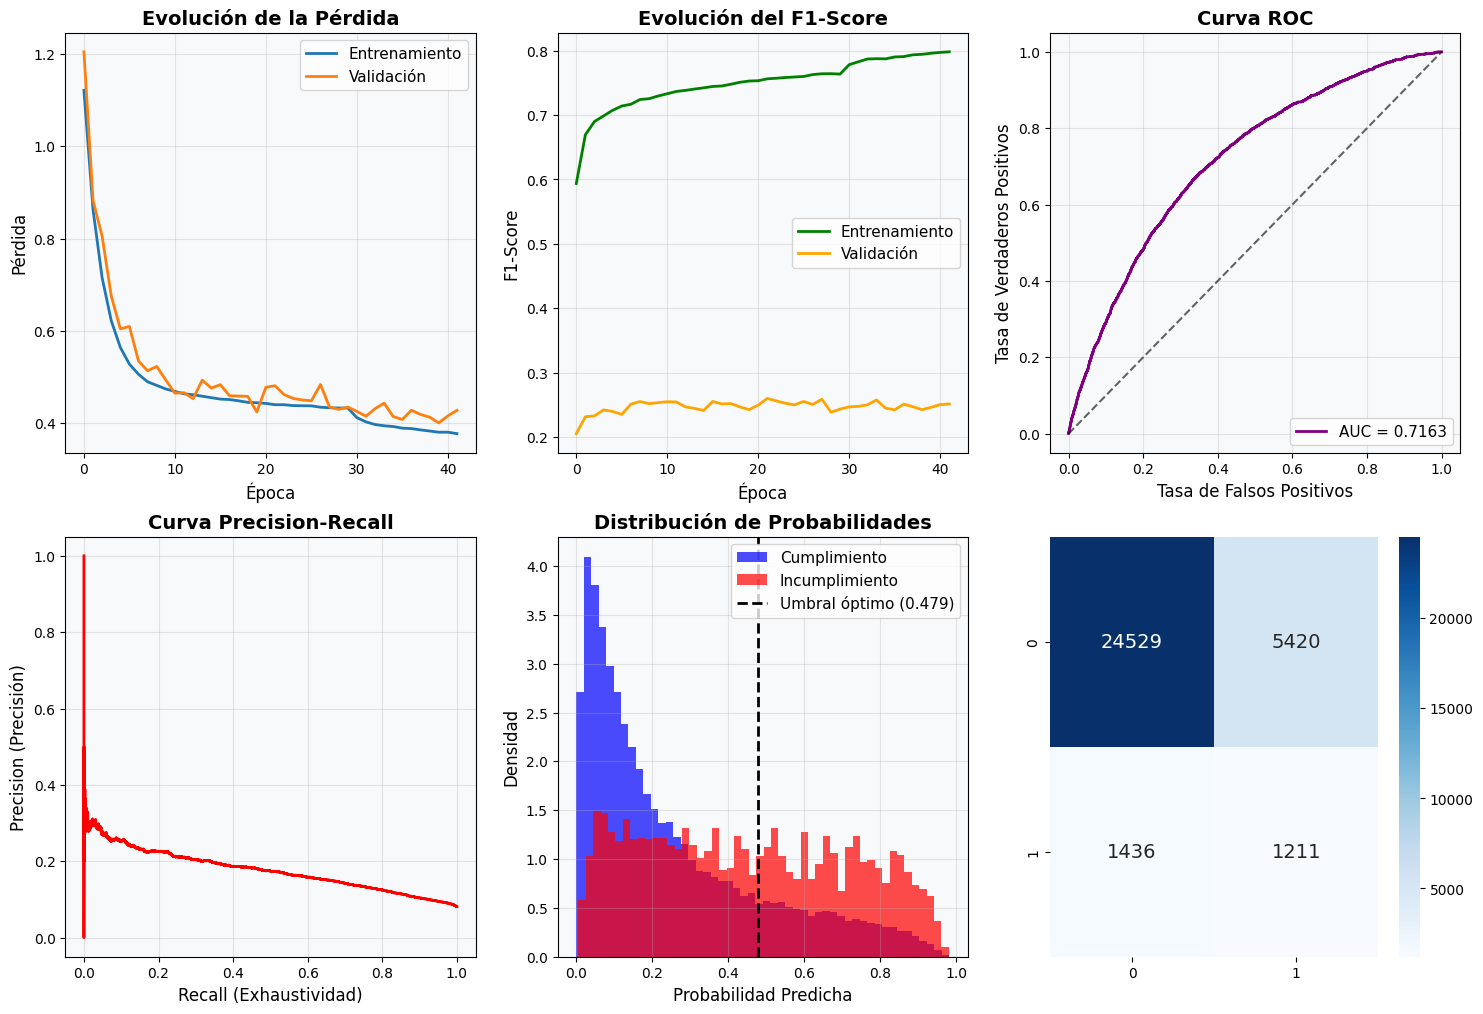

In [3]:
# ============================================================================
# 14. VISUALIZACIONES DE RESULTADOS
# ============================================================================

print("\n✓ Generando visualizaciones...")

# Crear figura con subplots
figura, ejes = plt.subplots(2, 3, figsize=(18, 12))

# ========== 14.1. Curva de pérdida durante entrenamiento ==========

ejes[0, 0].plot(historial.history['loss'], label='Entrenamiento', linewidth=2)
ejes[0, 0].plot(historial.history['val_loss'], label='Validación', linewidth=2)
ejes[0, 0].set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
ejes[0, 0].set_xlabel('Época', fontsize=12)
ejes[0, 0].set_ylabel('Pérdida', fontsize=12)
ejes[0, 0].legend(fontsize=11)
ejes[0, 0].grid(True, alpha=0.3)
ejes[0, 0].set_facecolor('#f8f9fa')

# ========== 14.2. Curva de F1-Score durante entrenamiento ==========

ejes[0, 1].plot(
    historial.history['f1_score'], 
    label='Entrenamiento', 
    linewidth=2,
    color='green'
)
ejes[0, 1].plot(
    historial.history['val_f1_score'], 
    label='Validación', 
    linewidth=2,
    color='orange'
)
ejes[0, 1].set_title('Evolución del F1-Score', fontsize=14, fontweight='bold')
ejes[0, 1].set_xlabel('Época', fontsize=12)
ejes[0, 1].set_ylabel('F1-Score', fontsize=12)
ejes[0, 1].legend(fontsize=11)
ejes[0, 1].grid(True, alpha=0.3)
ejes[0, 1].set_facecolor('#f8f9fa')

# ========== 14.3. Curva ROC ==========

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_prueba, probabilidades_prediccion)
auc_valor = roc_auc_score(y_prueba, probabilidades_prediccion)

ejes[0, 2].plot(
    fpr, 
    tpr, 
    label=f'AUC = {auc_valor:.4f}', 
    linewidth=2,
    color='purple'
)
ejes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.6)  # Línea de referencia
ejes[0, 2].set_title('Curva ROC', fontsize=14, fontweight='bold')
ejes[0, 2].set_xlabel('Tasa de Falsos Positivos', fontsize=12)
ejes[0, 2].set_ylabel('Tasa de Verdaderos Positivos', fontsize=12)
ejes[0, 2].legend(fontsize=11, loc='lower right')
ejes[0, 2].grid(True, alpha=0.3)
ejes[0, 2].set_facecolor('#f8f9fa')

# ========== 14.4. Curva Precision-Recall ==========

ejes[1, 0].plot(
    recall, 
    precision, 
    linewidth=2,
    color='red'
)
ejes[1, 0].set_title('Curva Precision-Recall', fontsize=14, fontweight='bold')
ejes[1, 0].set_xlabel('Recall (Exhaustividad)', fontsize=12)
ejes[1, 0].set_ylabel('Precision (Precisión)', fontsize=12)
ejes[1, 0].grid(True, alpha=0.3)
ejes[1, 0].set_facecolor('#f8f9fa')

# ========== 14.5. Distribución de probabilidades ==========

# Histograma para clase Cumplimiento (0)
ejes[1, 1].hist(
    probabilidades_prediccion[y_prueba == 0], 
    bins=50, 
    alpha=0.7, 
    label='Cumplimiento', 
    density=True,
    color='blue'
)

# Histograma para clase Incumplimiento (1)
ejes[1, 1].hist(
    probabilidades_prediccion[y_prueba == 1], 
    bins=50, 
    alpha=0.7, 
    label='Incumplimiento', 
    density=True,
    color='red'
)

# Línea vertical para umbral óptimo
ejes[1, 1].axvline(
    x=umbral_optimo, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Umbral óptimo ({umbral_optimo:.3f})'
)

ejes[1, 1].set_title('Distribución de Probabilidades', fontsize=14, fontweight='bold')
ejes[1, 1].set_xlabel('Probabilidad Predicha', fontsize=12)
ejes[1, 1].set_ylabel('Densidad', fontsize=12)
ejes[1, 1].legend(fontsize=11)
ejes[1, 1].grid(True, alpha=0.3)
ejes[1, 1].set_facecolor('#f8f9fa')

# ========== 14.6. Matriz de confusión ==========

# Calcular matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, predicciones_optimas)

# Crear heatmap de matriz de confusión
sns.heatmap(
    matriz_confusion, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=True,
    ax=ejes[1, 2],
    annot_kws={'size': 14}
)